In [2]:
import pandas as pd
import os

OUTPUT_DIR = "detectors_data_raw"

In [21]:
# Make a working copy
df_clean = pd.read_csv(os.path.join(OUTPUT_DIR, "raw_traffic.csv"), sep=",")

# Rename columns to English
df_clean = df_clean.rename(columns={
    "detid_15": "detector_id",
    "tag": "date",
    "stunde": "hour",
    "qualitaet": "quality",
    "q_kfz_det_hr": "veh_total",
    "v_kfz_det_hr": "speed_total",
    "q_pkw_det_hr": "veh_cars",
    "v_pkw_det_hr": "speed_cars",
    "q_lkw_det_hr": "veh_trucks",
    "v_lkw_det_hr": "speed_trucks"
})

print("Renamed columns:", df_clean.columns.tolist())

Renamed columns: ['detector_id', 'date', 'hour', 'quality', 'veh_total', 'speed_total', 'veh_cars', 'speed_cars', 'veh_trucks', 'speed_trucks', 'timestamp', 'year', 'file_source']


In [22]:
df_clean.head()
df_clean.info()
df_clean.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37316922 entries, 0 to 37316921
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   detector_id   int64  
 1   date          object 
 2   hour          int64  
 3   quality       float64
 4   veh_total     int64  
 5   speed_total   float64
 6   veh_cars      int64  
 7   speed_cars    float64
 8   veh_trucks    int64  
 9   speed_trucks  float64
 10  timestamp     object 
 11  year          int64  
 12  file_source   object 
dtypes: float64(4), int64(6), object(3)
memory usage: 3.6+ GB


,detector_id,hour,quality,veh_total,speed_total,veh_cars,speed_cars,veh_trucks,speed_trucks,year
count,3.731692e+07,3.731692e+07,3.731692e+07,3.731692e+07,3.731692e+07,3.731692e+07,3.731692e+07,3.731692e+07,3.731692e+07,3.731692e+07
mean,1.001010e+14,1.153677e+01,9.896848e-01,2.509433e+02,4.445316e+01,2.347601e+02,4.488129e+01,1.626924e+01,3.228924e+01,2.019123e+03
std,2.801231e+04,6.908563e+00,3.934329e-02,2.182739e+02,1.479560e+01,2.075449e+02,1.511479e+01,3.943093e+01,1.995833e+01,2.719196e+00
min,1.001010e+14,0.000000e+00,7.500000e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,2.015000e+03
25%,1.001010e+14,6.000000e+00,1.000000e+00,6.700000e+01,3.830000e+01,6.000000e+01,3.900000e+01,2.000000e+00,1.980000e+01,2.017000e+03
50%,1.001010e+14,1.200000e+01,1.000000e+00,2.010000e+02,4.600000e+01,1.860000e+02,4.660000e+01,6.000000e+00,3.600000e+01,2.019000e+03
75%,1.001010e+14,1.800000e+01,1.000000e+00,3.880000e+02,5.250000e+01,3.640000e+02,5.300000e+01,1.700000e+01,4.700000e+01,2.021000e+03
max,1.001010e+14,2.300000e+01,5.000000e+00,3.819000e+03,2.650000e+02,3.819000e+03,2.660000e+02,3.557000e+03,3.020000e+02,2.024000e+03


In [23]:
# Check timestamps

df_clean["timestamp"] = pd.to_datetime(df_clean["timestamp"])
df_clean["date"] = pd.to_datetime(df_clean["date"], format="%d.%m.%Y")

print("Timestamp range:", df_clean["timestamp"].min(), "→", df_clean["timestamp"].max())

Timestamp range: 2015-01-01 00:00:00 → 2024-12-31 23:00:00


In [24]:
# Remove duplicates

before = len(df_clean)
df_clean = df_clean.drop_duplicates()
after = len(df_clean)

print(f"Removed {before - after} duplicate rows.")

Removed 1172 duplicate rows.


In [25]:
# Keep high quality data only

quality_threshold = 0.8

before = len(df_clean)
df_clean = df_clean[df_clean["quality"] >= quality_threshold]
after = len(df_clean)

print(f"Dropped {before - after} rows with low quality.")


Dropped 459507 rows with low quality.


In [26]:
# Physically impossible speeds

before = len(df_clean)
df_clean = df_clean[
    (df_clean["speed_total"] > 0) & (df_clean["speed_total"] <= 300)
]
after = len(df_clean)

print(f"Dropped {before - after} rows with impossible total speeds.")

for col in ["speed_cars", "speed_trucks"]:
    before = len(df_clean)
    df_clean = df_clean[(df_clean[col] > 0) & (df_clean[col] <= 300)]
    after = len(df_clean)
    print(f"{col}: dropped {before - after} rows.")

# volumes

for col in ["veh_total", "veh_cars", "veh_trucks"]:
    before = len(df_clean)
    df_clean = df_clean[(df_clean[col] >= 0) & (df_clean[col] <= 5000)]
    after = len(df_clean)
    print(f"{col}: dropped {before - after} rows.")

Dropped 747518 rows with impossible total speeds.
speed_cars: dropped 67765 rows.
speed_trucks: dropped 5542229 rows.
veh_total: dropped 0 rows.
veh_cars: dropped 0 rows.
veh_trucks: dropped 0 rows.


In [27]:
# Broken detectors

broken_detectors = []

for det, g in df_clean.groupby("detector_id"):
    speeds = g["speed_total"].dropna()

    # Constant speed
    if speeds.nunique() <= 2:
        broken_detectors.append(det)
        continue

    # Missing ratio (should have one row per hour)
    expected = g["timestamp"].nunique()
    if expected < 0.5 * ((g["timestamp"].max() - g["timestamp"].min()).days * 24 + 1):
        broken_detectors.append(det)

print("Broken detectors identified:", broken_detectors)


Broken detectors identified: [100101010000268, 100101010001278, 100101010002894, 100101010004312, 100101010004514, 100101010008554, 100101010014315, 100101010014618, 100101010016941, 100101010020678, 100101010022092, 100101010022904, 100101010024015, 100101010024116, 100101010025025, 100101010025227, 100101010025328, 100101010026540, 100101010026742, 100101010027247, 100101010027449, 100101010030479, 100101010030681, 100101010031792, 100101010032503, 100101010032604, 100101010033513, 100101010036038, 100101010036139, 100101010039977, 100101010041694, 100101010042001, 100101010042203, 100101010052711, 100101010053014, 100101010053317, 100101010055741, 100101010056044, 100101010056246, 100101010058266, 100101010058569, 100101010060084, 100101010061300, 100101010062108, 100101010063219, 100101010063320, 100101010068168, 100101010068471, 100101010068774, 100101010072515, 100101010073020, 100101010078575, 100101010079181, 100101010081205, 100101010081407, 100101010081912, 100101010082013, 1

In [28]:
# check missing hours

missing_report = {}

for det, g in df_clean.groupby("detector_id"):
    ts = g["timestamp"]
    full = pd.date_range(ts.min(), ts.max(), freq="H")
    missing = len(full) - len(ts)
    missing_report[det] = missing

print("Detectors with high missing values:")
{k: v for k, v in missing_report.items() if v > 200}  # threshold adjustable


C:\Users\adib4\AppData\Local\Temp\ipykernel_35364\3840505542.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full = pd.date_range(ts.min(), ts.max(), freq="H")


Detectors with high missing values:


{100101010000167: 20934,
 100101010000268: 68229,
 100101010000369: 24001,
 100101010000470: 30653,
 100101010000874: 20453,
 100101010000975: 22791,
 100101010001076: 16690,
 100101010001177: 19305,
 100101010001278: 53353,
 100101010001379: 19222,
 100101010001884: 14604,
 100101010001985: 23916,
 100101010002086: 12605,
 100101010002288: 9590,
 100101010002389: 13079,
 100101010002490: 15749,
 100101010002591: 21928,
 100101010002692: 9232,
 100101010002793: 24258,
 100101010002894: 69154,
 100101010002995: 24336,
 100101010003096: 21590,
 100101010003100: 24512,
 100101010003201: 20031,
 100101010003302: 15434,
 100101010003403: 21671,
 100101010003504: 12503,
 100101010003605: 29289,
 100101010003908: 19732,
 100101010004009: 41156,
 100101010004110: 12454,
 100101010004211: 35095,
 100101010004312: 48474,
 100101010004413: 38264,
 100101010004514: 56999,
 100101010004918: 21587,
 100101010005019: 33863,
 100101010005120: 27287,
 100101010007948: 21594,
 100101010008049: 23234,
 1

In [29]:
print(df_clean.info())
print(df_clean.describe())
print("Final dataset rows:", len(df_clean))
print("Unique detectors:", df_clean['detector_id'].nunique())
print("Time range:", df_clean.timestamp.min(), "→", df_clean.timestamp.max())


<class 'pandas.core.frame.DataFrame'>
Index: 30498731 entries, 2 to 37316915
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   detector_id   int64         
 1   date          datetime64[ns]
 2   hour          int64         
 3   quality       float64       
 4   veh_total     int64         
 5   speed_total   float64       
 6   veh_cars      int64         
 7   speed_cars    float64       
 8   veh_trucks    int64         
 9   speed_trucks  float64       
 10  timestamp     datetime64[ns]
 11  year          int64         
 12  file_source   object        
dtypes: datetime64[ns](2), float64(4), int64(6), object(1)
memory usage: 3.2+ GB
None
        detector_id                           date          hour  \
count  3.049873e+07                       30498731  3.049873e+07   
mean   1.001010e+14  2019-07-22 07:50:30.844885248  1.184871e+01   
min    1.001010e+14            2015-01-01 00:00:00  0.000000e+00   
25%    1.001010e+14   

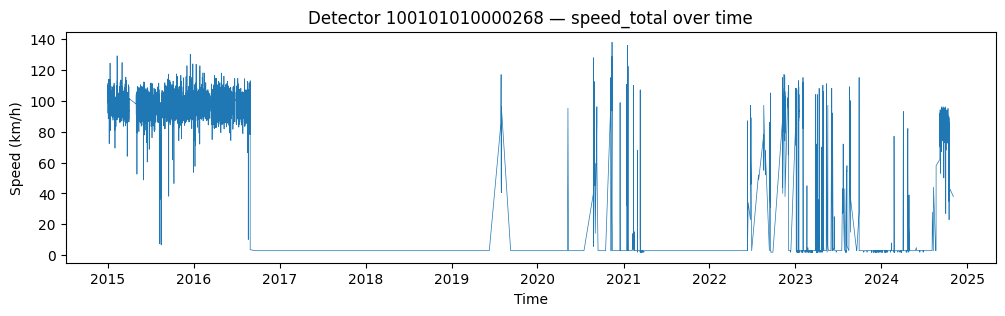

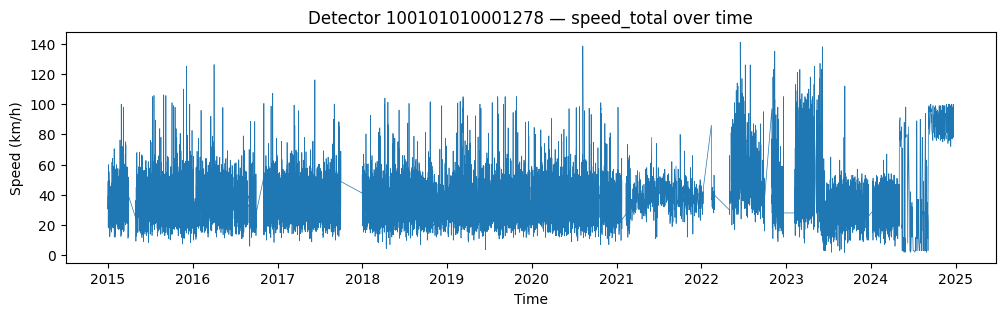

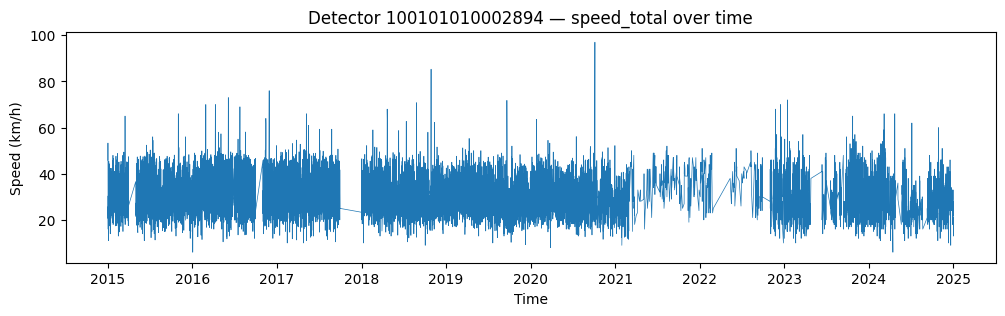

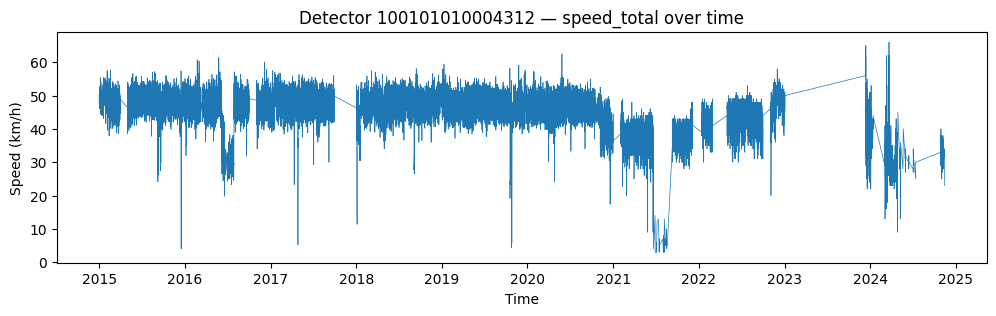

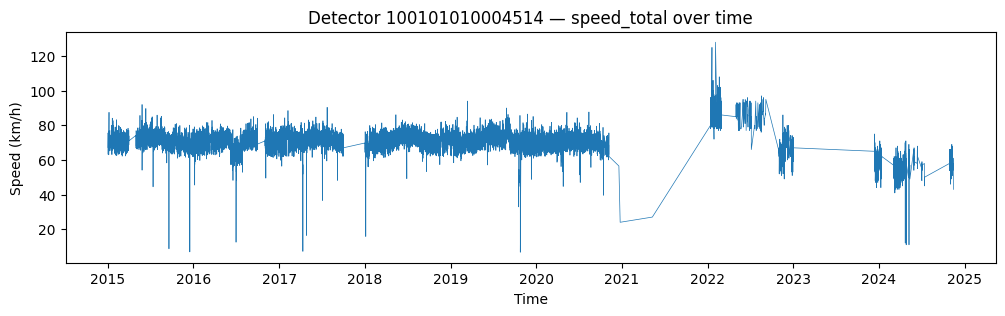

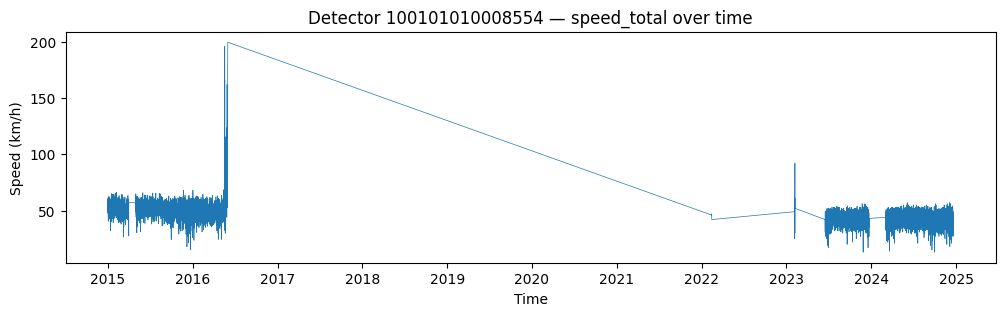

In [32]:
# Visualize some broken detectors

import matplotlib.pyplot as plt

sample_broken = list(broken_detectors)[:6]  # first 6 broken detectors

for det in sample_broken:
    g = df_clean[df_clean["detector_id"] == det].copy()
    g = g.sort_values("timestamp")
    
    plt.figure(figsize=(12, 3))
    plt.plot(g["timestamp"], g["speed_total"], linewidth=0.5)
    plt.title(f"Detector {det} — speed_total over time")
    plt.xlabel("Time")
    plt.ylabel("Speed (km/h)")
    plt.show()


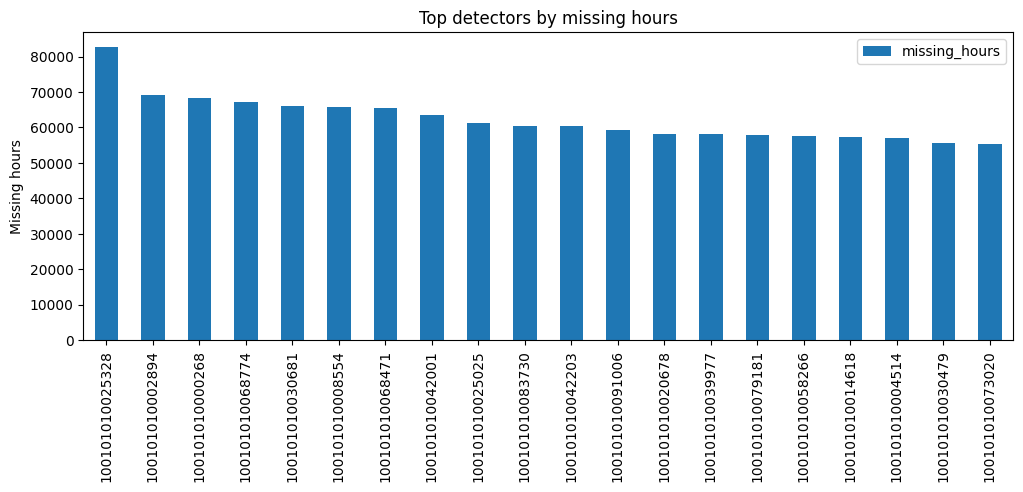

In [33]:

# Convert dictionary to DataFrame
missing_df = pd.DataFrame.from_dict(missing_report, orient="index", columns=["missing_hours"])
missing_df = missing_df.sort_values("missing_hours", ascending=False)

missing_df.head(20).plot(kind="bar", figsize=(12, 4))
plt.title("Top detectors by missing hours")
plt.ylabel("Missing hours")
plt.show()


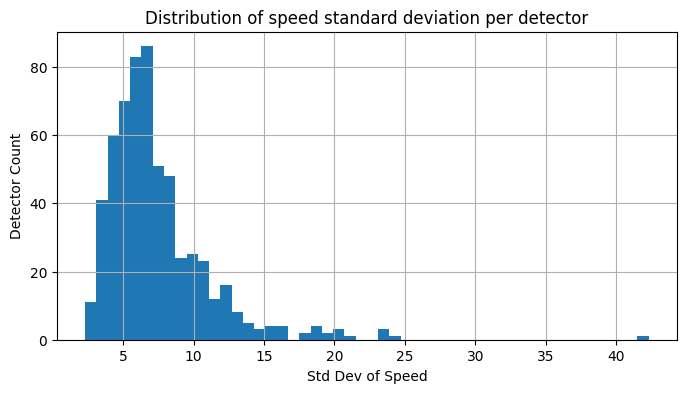

Detectors with speed_std < 2: 0


In [35]:
import numpy as np

var_df = (
    df_clean.groupby("detector_id")["speed_total"]
    .std()
    .reset_index(name="speed_std")
    .sort_values("speed_std")
)

var_df["speed_std"].hist(bins=50, figsize=(8,4))
plt.title("Distribution of speed standard deviation per detector")
plt.xlabel("Std Dev of Speed")
plt.ylabel("Detector Count")
plt.show()

print("Detectors with speed_std < 2:", var_df[var_df["speed_std"] < 2].shape[0])


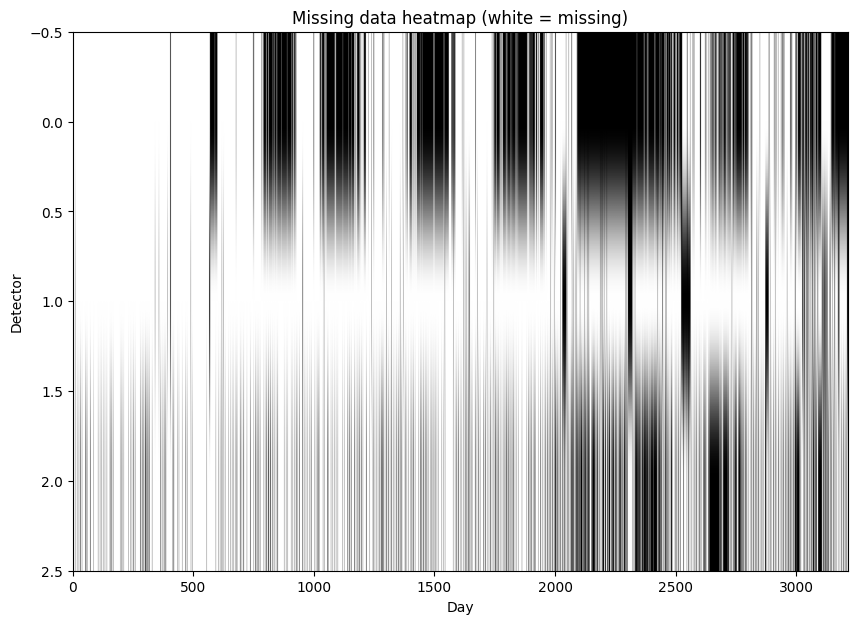

In [37]:
sample = df_clean[df_clean["detector_id"].isin(list(broken_detectors)[:3])].copy()

pivot = (
    sample
    .assign(hour=sample["timestamp"].dt.hour,
            day=sample["timestamp"].dt.date)
    .pivot_table(values="speed_total", index="day", columns="detector_id")
)

plt.figure(figsize=(10,7))
plt.imshow(pivot.isna().T, aspect="auto", cmap="Greys")
plt.title("Missing data heatmap (white = missing)")
plt.xlabel("Day")
plt.ylabel("Detector")
plt.show()


In [38]:
# -------- CONFIG --------
# Threshold for “too many missing hours”
# (1 year = 8760 hours, 10 years ≈ 87,600)
MISSING_THRESHOLD = 30000 

# missing_report is assumed to be a dict: {detector_id: missing_hours}

# -------- BUILD DROP LIST --------
detectors_too_missing = [
    det for det, miss in missing_report.items()
    if miss > MISSING_THRESHOLD
]

print("Detectors with excessive missing hours:", len(detectors_too_missing))

# Combine with the broken detectors list
detectors_to_drop = set(broken_detectors) | set(detectors_too_missing)

print("Total detectors to drop:", len(detectors_to_drop))
print("Sample:", list(detectors_to_drop)[:10])

Detectors with excessive missing hours: 168
Total detectors to drop: 171
Sample: [100101010052610, 100101010090501, 100101010014214, 100101010044425, 100101010074636, 100101010013204, 100101010020375, 100101010035735, 100101010058266, 100101010005019]


In [39]:
# -------- DROP FROM CLEAN DF --------
before = len(df_clean)
df_clean = df_clean[~df_clean["detector_id"].isin(detectors_to_drop)]
after = len(df_clean)

print(f"Rows dropped: {before - after}")
print(f"Remaining rows: {after}")
print(f"Remaining detectors: {df_clean['detector_id'].nunique()}")


Rows dropped: 7467436
Remaining rows: 23031295
Remaining detectors: 420


In [40]:
print(df_clean.info())
print(df_clean.describe())
print("Final dataset rows:", len(df_clean))
print("Unique detectors:", df_clean['detector_id'].nunique())

<class 'pandas.core.frame.DataFrame'>
Index: 23031295 entries, 2 to 37316915
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   detector_id   int64         
 1   date          datetime64[ns]
 2   hour          int64         
 3   quality       float64       
 4   veh_total     int64         
 5   speed_total   float64       
 6   veh_cars      int64         
 7   speed_cars    float64       
 8   veh_trucks    int64         
 9   speed_trucks  float64       
 10  timestamp     datetime64[ns]
 11  year          int64         
 12  file_source   object        
dtypes: datetime64[ns](2), float64(4), int64(6), object(1)
memory usage: 2.4+ GB
None
        detector_id                           date          hour  \
count  2.303130e+07                       23031295  2.303130e+07   
mean   1.001010e+14  2019-08-06 23:58:15.849397760  1.178570e+01   
min    1.001010e+14            2015-01-01 00:00:00  0.000000e+00   
25%    1.001010e+14   

In [41]:
df_clean.to_csv(os.path.join(OUTPUT_DIR, "cleaned_traffic.csv"), index=False)